In [75]:
import pandas as pd
import networkx as nx
from collections import Counter
import ast

In [125]:
#df = pd.read_json('C:/Users/lamersws1/Documents/Data/firstdata.json')
#df = pd.read_csv('C:/Users/lamersws1/Documents/GitHub/data_opensource.csv')
#df['user'] = df['user'].apply(lambda x: ast.literal_eval(x))
#df['entities'] = df['entities'].apply(lambda x: ast.literal_eval(x))

In [126]:
df.head()

,index,coordinates,created_at,user,timestamp_ms,text,retweet_count,retweeted_status,reply_count,entities
0,0,None,2018-05-25 15:03:49,"{'id': 2516920201, 'id_str': '2516920201', 'na...",2018-05-25 15:03:49.562,??? https://t.co/es4daoZHSf,0.0,None,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.c..."
1,1,None,2018-05-25 15:03:53,"{'id': 2682920203, 'id_str': '2682920203', 'na...",2018-05-25 15:03:53.259,#Hipismo Chuvi jimenez también es hipismo y ya...,0.0,None,0.0,"{'hashtags': [{'text': 'Hipismo', 'indices': [..."
10,10,None,2018-05-25 15:04:04,"{'id': 734197130, 'id_str': '734197130', 'name...",2018-05-25 15:04:04.847,@AaronHawryluk @elonmusk You didn't even let h...,0.0,None,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.c..."
100,100,None,2018-05-25 15:08:26,"{'id': 387019950, 'id_str': '387019950', 'name...",2018-05-25 15:08:26.309,RT @EYFrance: C’est parti pour le talk sur le ...,0.0,{'created_at': 'Fri May 25 13:47:53 +0000 2018...,0.0,"{'hashtags': [{'text': 'VivaTech', 'indices': ..."
1000,1000,None,2018-05-25 15:46:24,"{'id': 1004141089, 'id_str': '1004141089', 'na...",2018-05-25 15:46:24.481,The New Frontier of Fundraising: An Insider’s ...,0.0,None,0.0,"{'hashtags': [{'text': 'fundraising', 'indices..."


Explore available collumns

In [127]:
list(df)

['index',
 'coordinates',
 'created_at',
 'user',
 'timestamp_ms',
 'text',
 'retweet_count',
 'retweeted_status',
 'reply_count',
 'entities']

In [128]:
df.describe()

,index,retweet_count,reply_count
count,150000.000000,149999.0,149999.0
mean,4999.500000,0.0,0.0
std,2886.760954,0.0,0.0
min,0.000000,0.0,0.0
25%,2499.750000,0.0,0.0
50%,4999.500000,0.0,0.0
75%,7499.250000,0.0,0.0
max,9999.000000,0.0,0.0


Let's look at hashtags

In [129]:
df[df['entities'].isnull()]

,index,coordinates,created_at,user,timestamp_ms,text,retweet_count,retweeted_status,reply_count,entities
3758,3758,None,NaT,None,NaT,None,NaN,None,NaN,None


Remove this useless record from the data

In [130]:
df = df[df['entities'].isnull() == False]

Let's look at the mentions network

In [131]:
def extract_mentions(df):

    out = []

    for index, row in df.iterrows():

        if isinstance(row.user, dict):
        
            assert isinstance(row.user, dict), "user is not dict in {}".format(index)
            assert isinstance(row.entities, dict), "entities is not dict in {}".format(index)
            usermentions = row.entities['user_mentions']

            for u in usermentions:
                out.append((row.user['id'], u['id']))
    
    #out = [o for o in out if o[0]!=o[1]]
    
    return out

In [132]:
mentions = extract_mentions(df)
len(mentions)

198291

In [133]:
def extract_users(df):
    
    users = [(u['id'], u['screen_name'], u['name']) for u in df['user'] if isinstance(u, dict)]
    users = list(set(users))
    
    user_mentions = [u['user_mentions'] for u in df['entities'] if isinstance(u, dict)]
    for l in user_mentions:
        for u in l:
            users.append((u['id'], u['screen_name'], u['name']))
        
    users = list(set(users))
    
    users = {u[0]: {'name': u[2], 'screen_name': u[1]} for u in users}
    
    return users


In [134]:
users = extract_users(df)

In [135]:
def user_count_tweets(df):
    users = [u['id'] for u in df['user'] if isinstance(u, dict)]
    
    users = Counter(users)
    
    return {x[0]: {'n_tweets': x[1]} for x in users.most_common()}

user_tweetcounts = user_count_tweets(df)

In [136]:
#add weights to edges
mentions_w = Counter(mentions)
mentions_w = [(e[0], e[1], mentions_w[e]) for e in mentions_w]

In [137]:
G=nx.Graph()
G.add_weighted_edges_from(mentions_w)
nx.set_node_attributes(G, users)
nx.set_node_attributes(G, user_tweetcounts)

Get giant component, discard rest

Get only those nodes with degree > 25, then get giant component of those

In [138]:
GC = sorted(nx.connected_components(G), key=len, reverse=True)[0]
SG = G.subgraph(GC)
top_connected_nodes = [x[0] for x in SG.degree() if x[1] >= 25]
SG = SG.subgraph(top_connected_nodes)
SG = SG.subgraph(sorted(nx.connected_components(SG), key=len, reverse=True)[0])

In [120]:
len(SG.nodes)

18928

In [121]:
#nx.draw_networkx(SG)

C:\Users\lamersws1\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\layout.py:595: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


KeyboardInterrupt: 

In [122]:
SG.nodes

NodeView((1000224483993702400, 2548144838, 1000225932701908994, 1000225939995942912, 1000230375178866688, 1000234378302287873, 1000235229150232577, 1000236724071550976, 1000239427363405824, 1000240371824115712, 1000237986565386240, 1000242042247745536, 1000241791264636929, 1000246604249509888, 1000254720630403072, 1000259331688947712, 1000260352787927040, 1000264112310439937, 1000279698218278914, 1000283115145773056, 1000286561278160896, 1000290871374475264, 1000296191123324928, 1000298119567945728, 1000297148561412096, 1000297785558814720, 1000300086335651840, 1000301582913859584, 1000307863988985856, 1000311358196416512, 1000311593861660672, 1000311925094334465, 1000314646698459136, 1000318649117429760, 17877830, 1000318757317763073, 1000322702765314048, 1000322898752552960, 1000320047200456705, 1000329060839391232, 1000333317567275008, 1000333930258513921, 1000343663677968384, 1000343511403655169, 1000343508606246913, 1000347881495134208, 1000045719376531456, 1000351303598510080, 10

In [123]:
relabeldict = {key: val['screen_name'] for key, val in users.items()}

In [124]:
nx.write_graphml(nx.relabel_nodes(SG, relabeldict),'mentions_network.graphml')

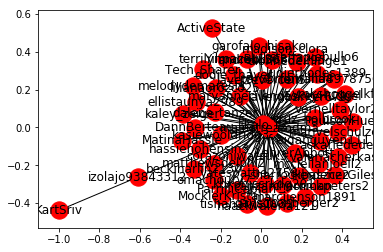

In [117]:
nx.draw_networkx(nx.relabel_nodes(SG, relabeldict))

In [77]:
#nx.write_graphml(nx.relabel_nodes(G.subgraph(GC), relabeldict),'mentions_network_full.graphml')